In [114]:
import os;import sys; sys.path.append('../../DataPreparation')
from cleaner import read_data
from helpers import convey_insights,display_with_scroll
sys.path.append("../../")
from utils import save_model,save_hyperparameters,load_hyperparameters,nice_table
from ModelPipelines.ModelAnalysis import evaluate, learning_curves,cross_validation,log_weights_analysis
from mlpath import mlquest as mlq
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.feature_selection import RFE

In [115]:
model_name= 'RandomForest'
model_adjusted_name= model_name
mlq.start_quest(model_name, table_dest="../../", log_defs=True)

# <font color="aqua">Random Forest </font> Model

###  Read the Data

In [116]:
x_data, y_data,_,_ = mlq.l(read_data)(split="train", nulls="mix",outliers="cap", standardize="normalize",encode='Binary',pca=0.9,skip=['RetentionCalls','RetentionOffersAccepted'], oversample='None')

### Default values of HyperParameters

In [117]:
nice_table(RandomForestClassifier().get_params())

bootstrap,ccp_alpha,class_weight,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
True,0.0,None,gini,None,sqrt,None,None,0.0,1,2,0.0,100,None,False,None,0,False


### Search Best Hyper Parameters

In [118]:
if os.path.exists(f"../../Saved/{model_adjusted_name}_opt_params.pkl") :
    opt_params=load_hyperparameters(model_adjusted_name)
    
else:
    model=mlq.l(RandomForestClassifier)()
    params = {
        "n_estimators": [10, 50, 100, 200],  # Number of trees in the forest
        "max_features": ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
        "max_depth": [None, 10, 20, 30],  # Maximum depth of the tree
        "min_samples_split": [2, 5, 10],  # Minimum number of samples required to split an internal node
        "min_samples_leaf": [1, 2, 4],  # Minimum number of samples required to be at a leaf node
        "bootstrap": [True, False],  # Whether to use bootstrap samples when building trees
        "class_weight": ['balanced']  # Weights associated with classes in the form {class_label: weight}
    }

    model = RandomizedSearchCV(model, params, n_iter=10, cv=5, verbose=3, n_jobs=-1,scoring="f1")
    model.fit(x_data, y_data)

    opt_params = model.best_params_
    save_hyperparameters(model_adjusted_name, opt_params)

In [119]:
nice_table(opt_params)

n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,class_weight,bootstrap
200,5,4,auto,10,balanced,False


### Train Model

In [120]:
model = mlq.l(RandomForestClassifier)(**opt_params)
model.fit(x_data,y_data)

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                       max_features='auto', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=200)

### Evaluate Model

In [121]:
y_pred=model.predict(x_data)
metrics=evaluate(y_pred=y_pred, y_true=y_data,title="Train Evaluation Metrics", table=True)

Accuracy,Precision,Recall,F1 Score,ROC AUC
0.69219,0.47815,0.78866,0.59535,0.721


### Model Generalization

In [122]:
scores=cross_validation(model,x_data,y_data)
convey_insights([
   "We can see that the model has bad generalization as the training score is much higher than the validation score", 
])

Accuracy_train,Precision_train,Recall_train,F1 Score_train,ROC AUC_train
0.71621,0.5037,0.80768,0.62043,0.84038


Accuracy_test,Precision_test,Recall_test,F1 Score_test,ROC AUC_test
0.6056,0.38497,0.62507,0.47646,0.65971


<h3><font color="pink" size=5>Insights</font></h3> <font size=4>
<font color="pink">✦</font> We can see that the model has bad generalization as the training score is much higher than the validation score<br><br></font>

### Model Learning Curve

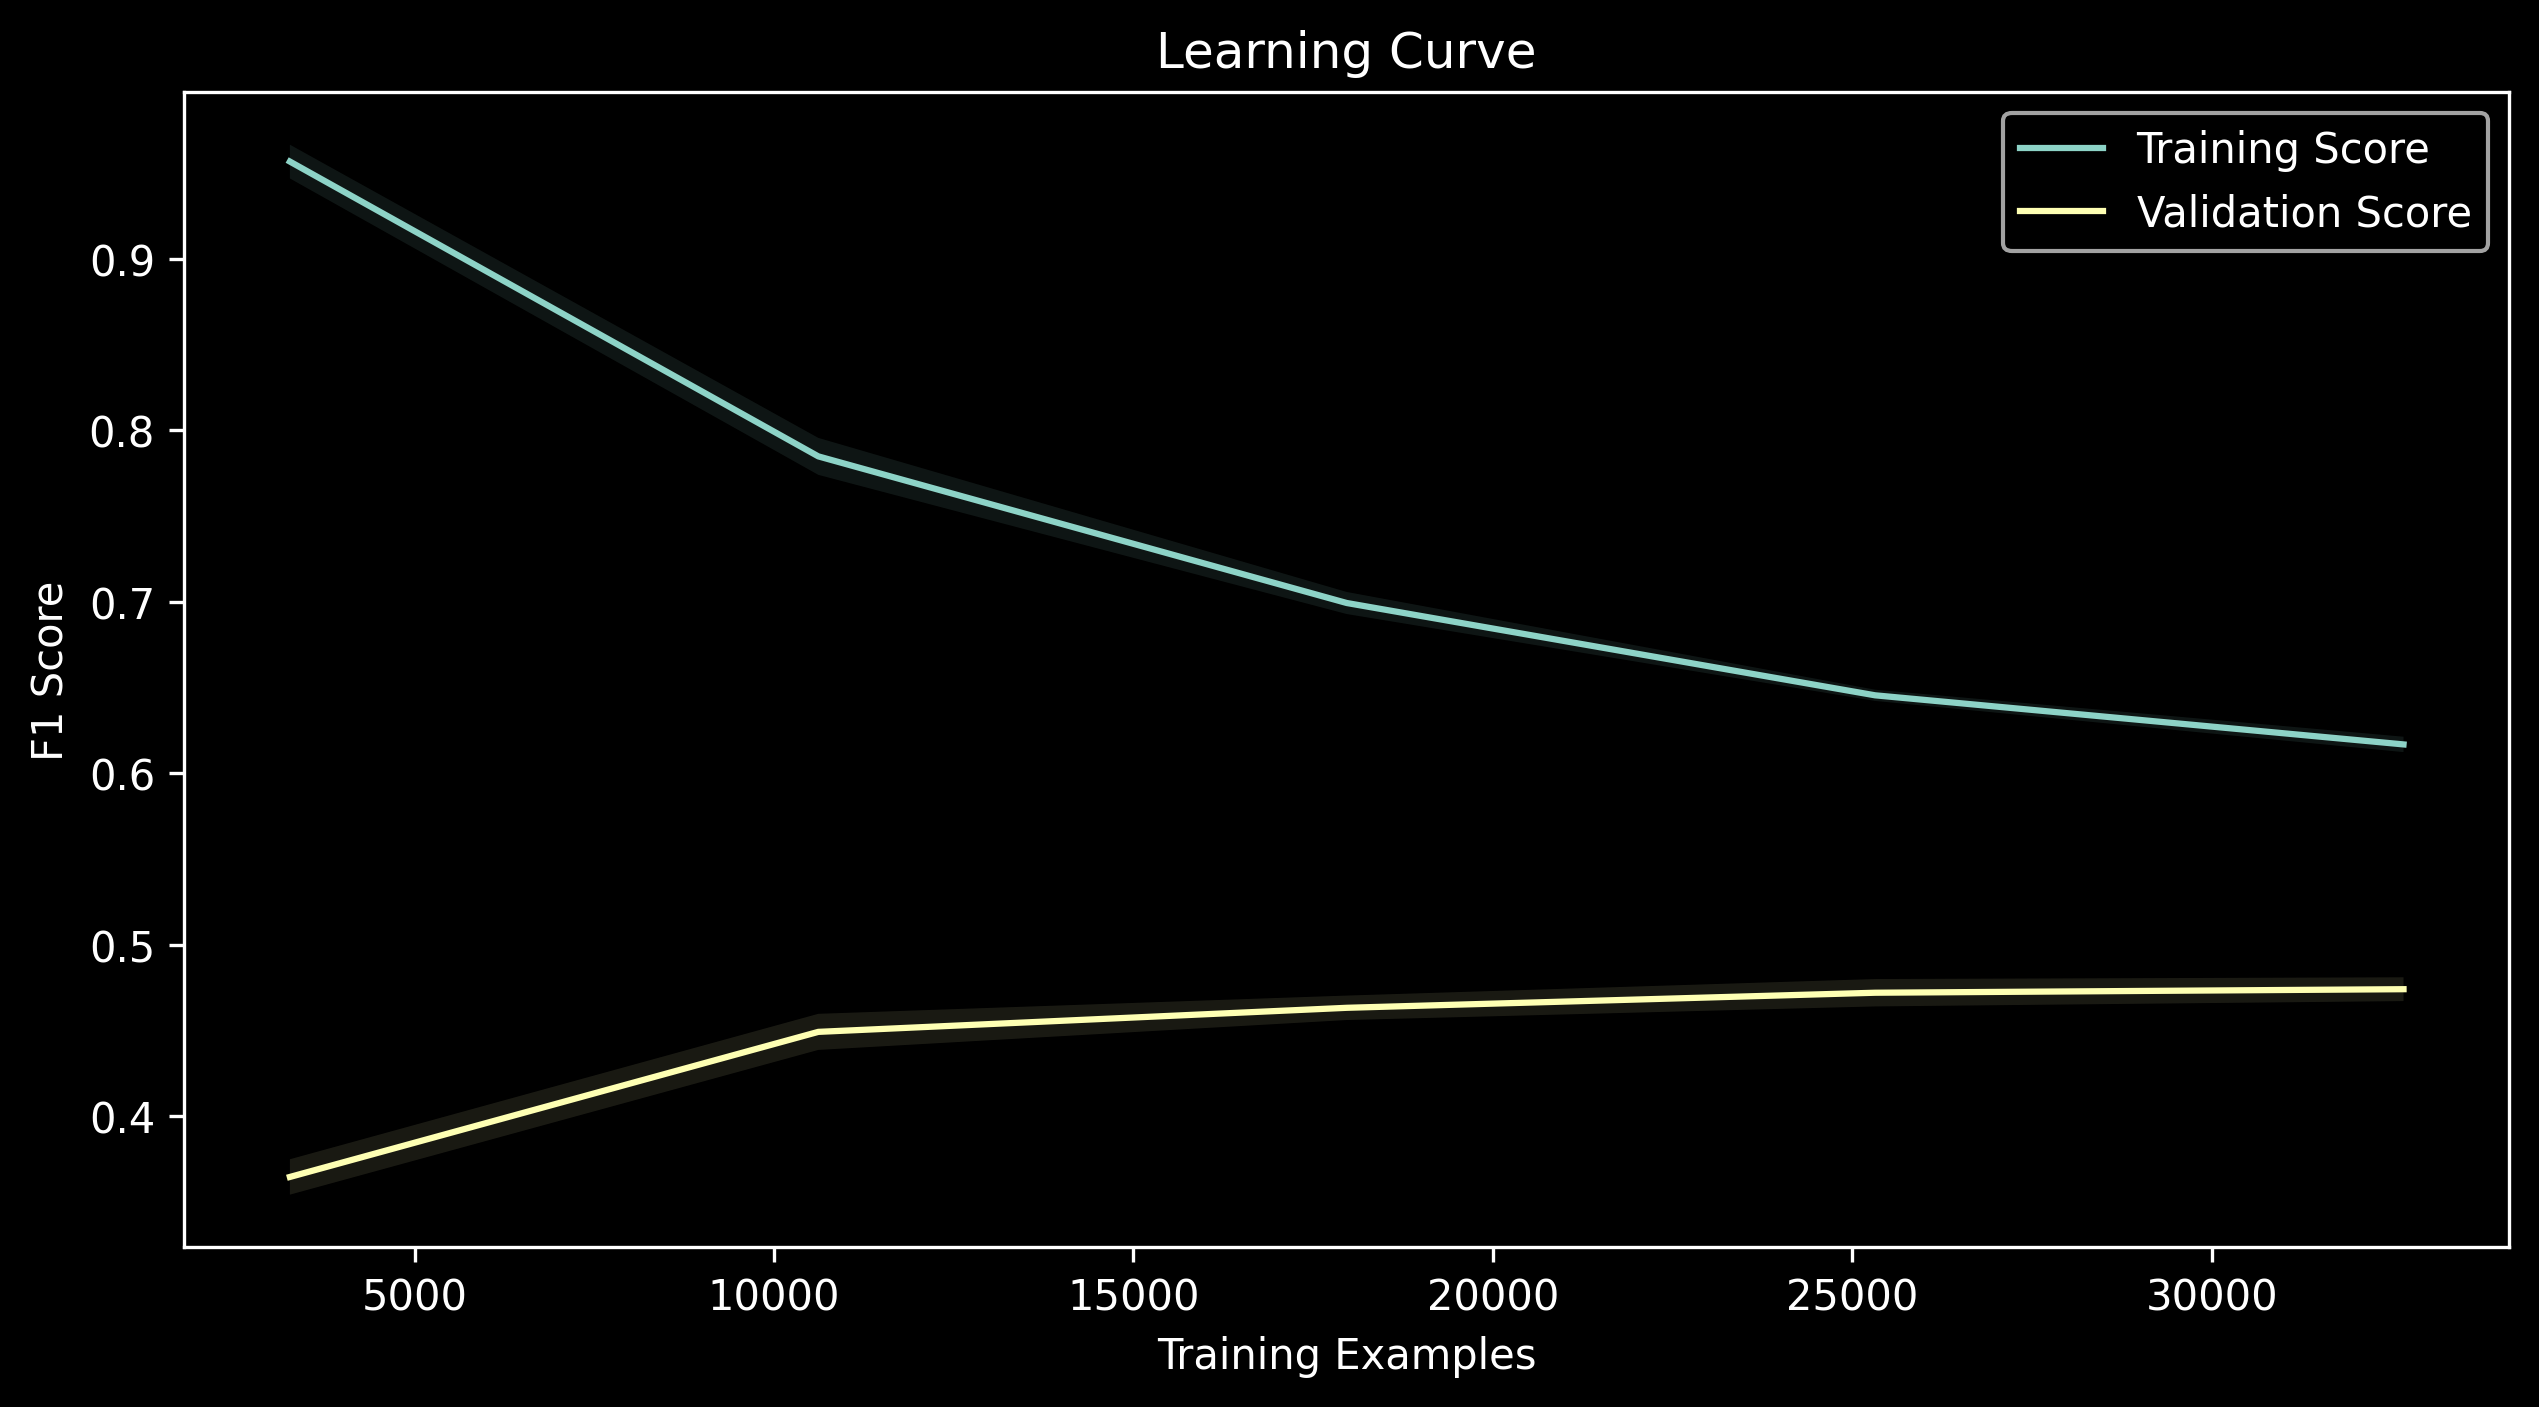

In [123]:
train_sizes = np.linspace(0.1, 1.0, 5)
learning_curves(model, x_data, y_data,N=train_sizes)

### Feature Selection

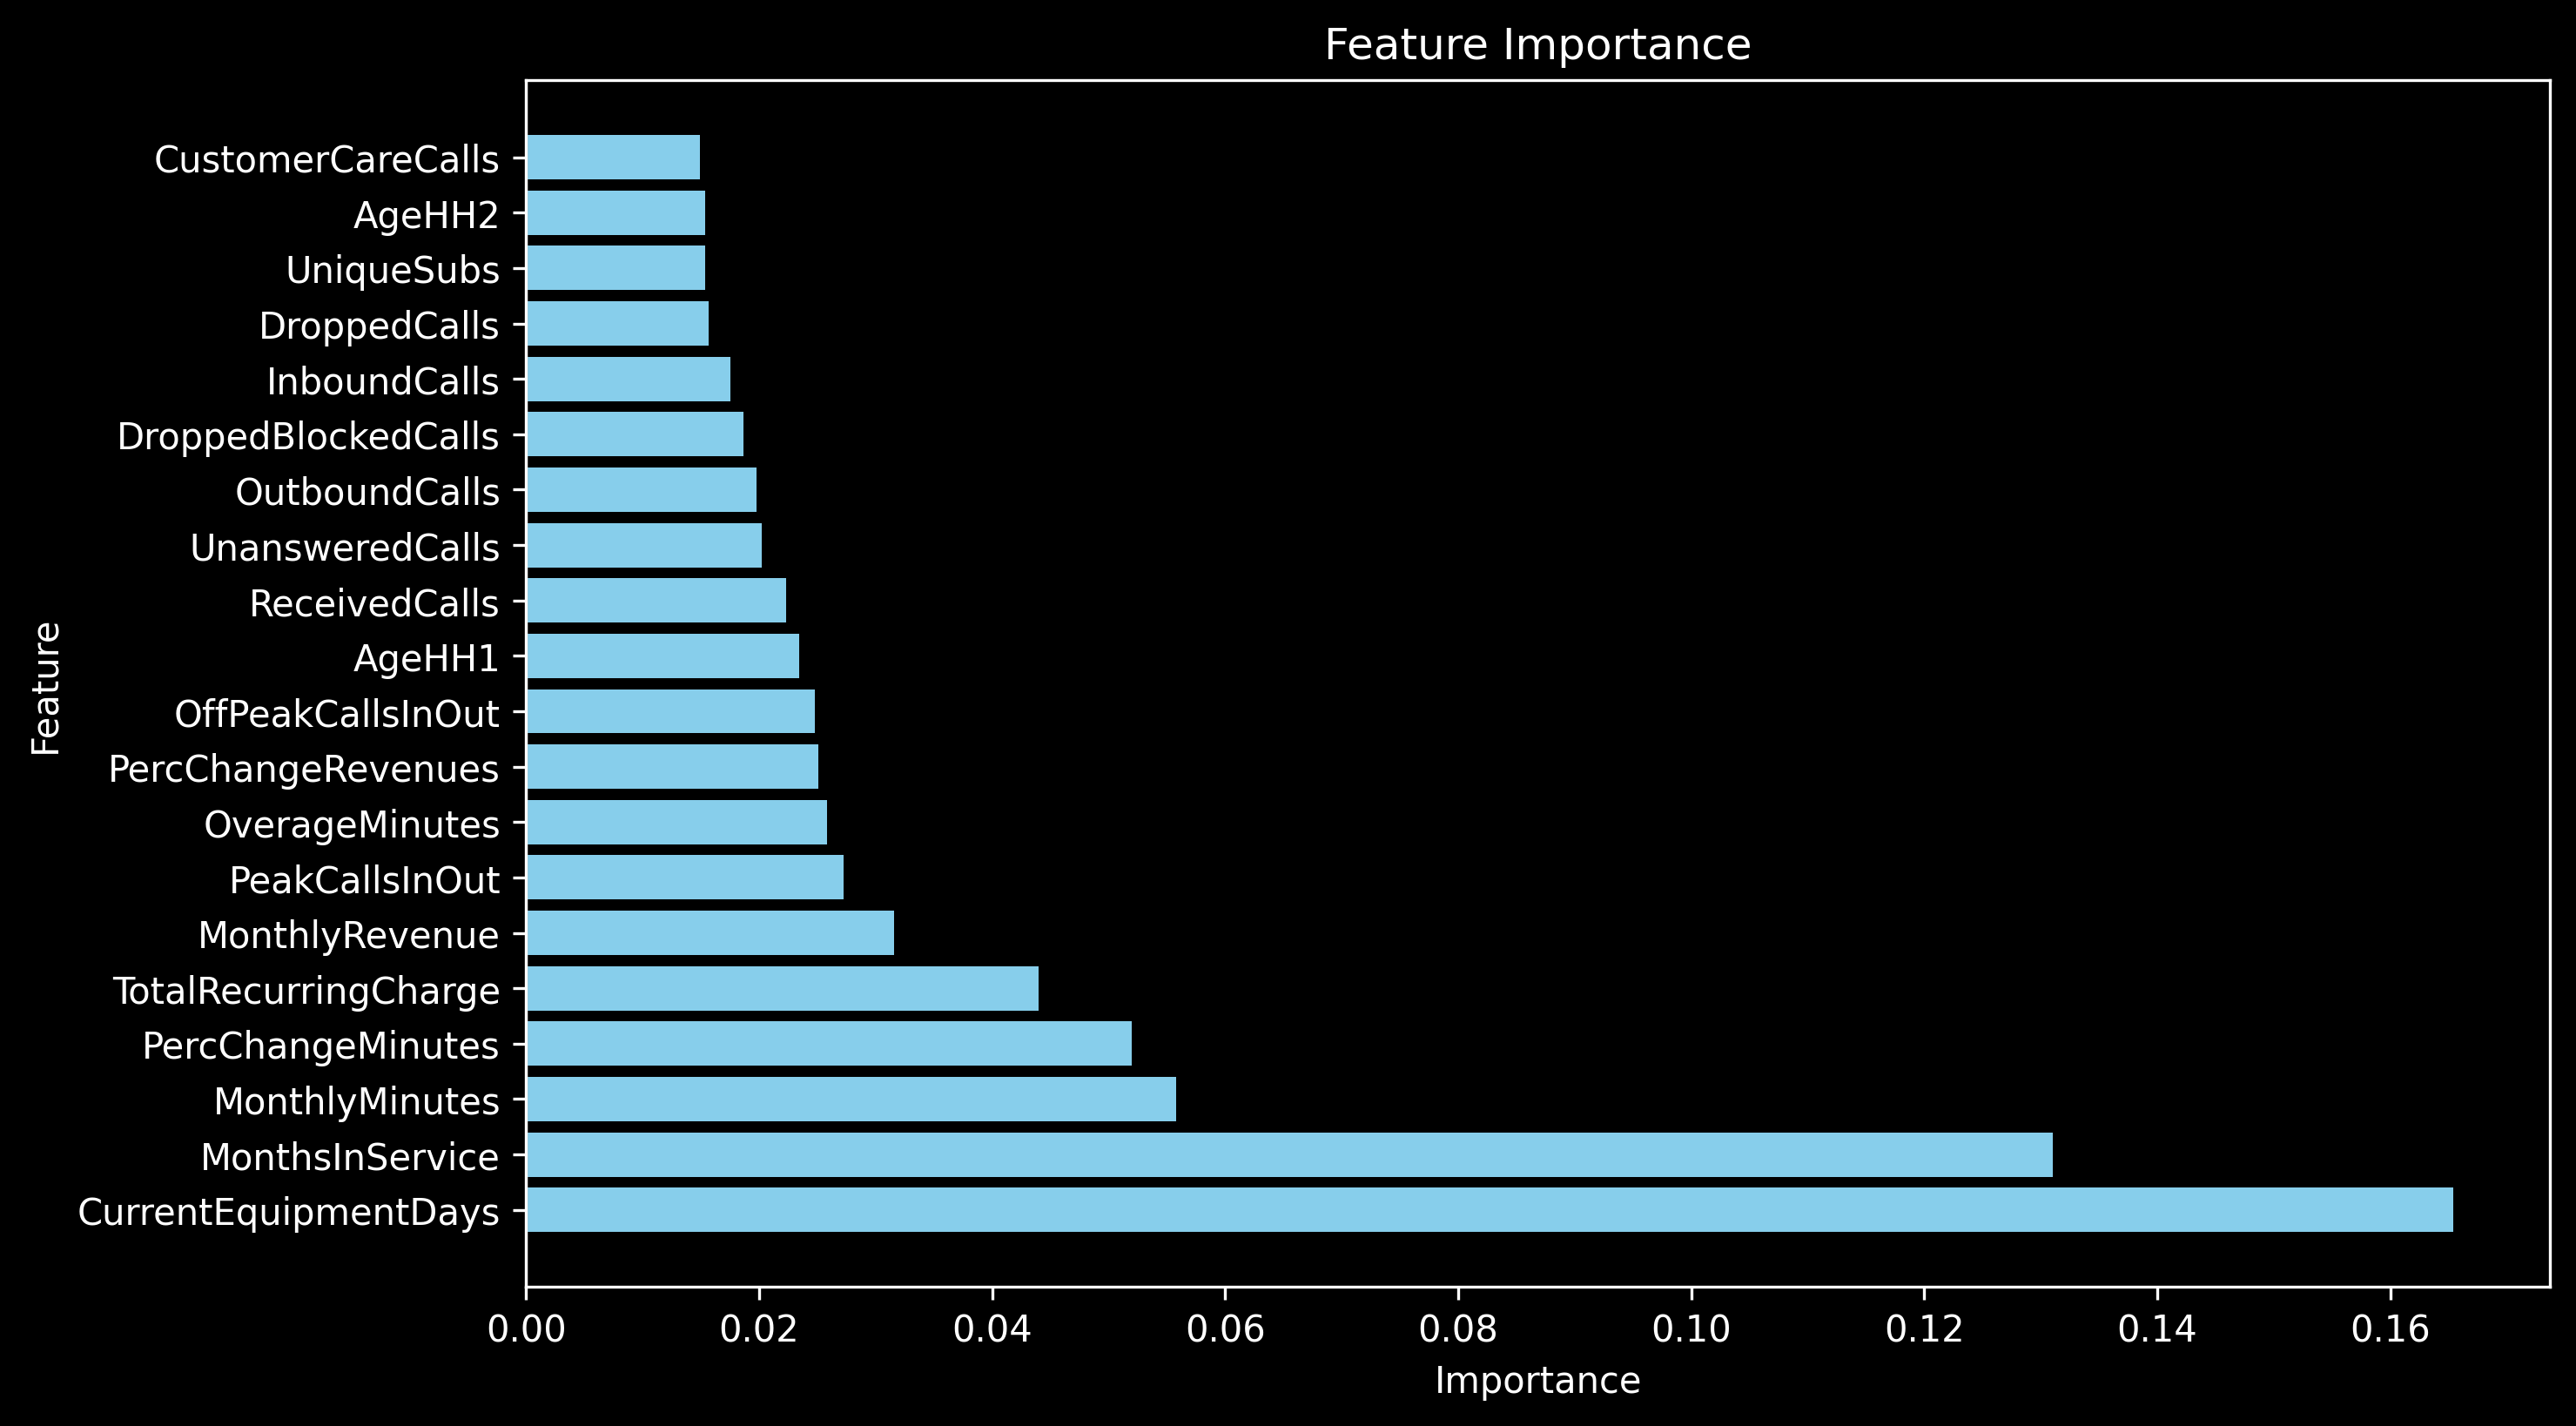

In [124]:
log_weights_analysis(model,x_data)


### Save Model

In [125]:
save_model(model_adjusted_name, model)

### Tracking

In [126]:
mlq.log_metrics(**scores)
mlq.end_quest()

In [127]:
mlq.show_logs(model_name, table_dest="../../", last_k=20)

In [137]:
convey_insights([
    'Results show that having PCA improves the model but with retaining a decent amount of the variance e.g. 0.9',
    'Results show that binary encoding is better than one hot encoding',
    "Standardize better than normalize",
    '"bootstrap" parameter is slightly better when set to False than to True, so can choose any ',
    "Not handling the outliers is better than caping them. This is shown by that not handling the outliers has a slighly lower F1 score test than capping them and lower F1 trainig score which means better generalization",
])

<h3><font color="pink" size=5>Insights</font></h3> <font size=4>
<font color="pink">✦</font> Results show that having PCA improves the model but with retaining a decent amount of the variance e.g. 0.9<br><br><font color="pink">✦</font> Results show that binary encoding is better than one hot encoding<br><br><font color="pink">✦</font> Standardize better than normalize<br><br><font color="pink">✦</font> "bootstrap" parameter is slightly better when set to False than to True, so can choose any <br><br><font color="pink">✦</font> Not handling the outliers is better than caping them. This is shown by that not handling the outliers has a slighly lower F1 score test than capping them and lower F1 trainig score which means better generalization<br><br></font>

### OverSampling

In [129]:
# # with oversampling

# mlq.start_quest(model_name, table_dest="../../", log_defs=True)


# x_train,x_val,y_train,y_val=mlq.l(read_data)(split="val", nulls="mix",outliers="cap", standardize="standardize",encode='Binary',pca=0.9,skip=['RetentionCalls','RetentionOffersAccepted'], oversample='random_oversampling')

# model = mlq.l(RandomForestClassifier)(**opt_params)
# model.fit(x_train,y_train)

# y_pred_train=model.predict(x_train)
# y_pred_val=model.predict(x_val)

# train_scores=evaluate(y_pred=y_pred_train, y_true=y_train,title="Train Evaluation Metrics", table=False)
# val_scores=evaluate(y_pred=y_pred_val, y_true=y_val,title="Val Evaluation Metrics", table=False)

# display(nice_table(train_scores,"Train Evaluation Metrics"))
# display(nice_table(val_scores,"Val Evaluation Metrics"))
# train_scores = {f"{key}_train": value for key, value in train_scores.items()}
# val_scores = {f"{key}_test": value for key, value in val_scores.items()}


# scores={**train_scores,**val_scores}
# mlq.log_metrics(**scores)
# mlq.end_quest()

In [130]:
# # without oversampling

# mlq.start_quest(model_name, table_dest="../../", log_defs=True)


# x_train,x_val,y_train,y_val=mlq.l(read_data)(split="val", nulls="mix",outliers="cap", standardize="standardize",encode='Binary',pca=0.9,skip=['RetentionCalls','RetentionOffersAccepted'], oversample='none')

# model = mlq.l(RandomForestClassifier)(**opt_params)
# model.fit(x_train,y_train)

# y_pred_train=model.predict(x_train)
# y_pred_val=model.predict(x_val)

# train_scores=evaluate(y_pred=y_pred_train, y_true=y_train,title="Train Evaluation Metrics", table=False)
# val_scores=evaluate(y_pred=y_pred_val, y_true=y_val,title="Val Evaluation Metrics", table=False)

# display(nice_table(train_scores,"Train Evaluation Metrics"))
# display(nice_table(val_scores,"Val Evaluation Metrics"))
# train_scores = {f"{key}_train": value for key, value in train_scores.items()}
# val_scores = {f"{key}_test": value for key, value in val_scores.items()}


# scores={**train_scores,**val_scores}
# mlq.log_metrics(**scores)
# mlq.end_quest()

In [131]:
mlq.show_logs(model_name, table_dest="../../", last_k=20)

###  Final Results

In [132]:
convey_insights(["SMOT (2) and adasyn(4) has  worse test Results as seen in the F1 score & recall & roc auc score that not handling oversampling at all. ",
                 "In fact SMOT (2) and adasyn(4) has higher training and lower testing (Overfitting)",
                 "Random oversampling seems to be comparable to not handling oversampling at all yet no oversampling is exceling",])

<h3><font color="pink" size=5>Insights</font></h3> <font size=4>
<font color="pink">✦</font> SMOT (2) and adasyn(4) has  worse test Results as seen in the F1 score & recall & roc auc score that not handling oversampling at all. <br><br><font color="pink">✦</font> In fact SMOT (2) and adasyn(4) has higher training and lower testing (Overfitting)<br><br><font color="pink">✦</font> Random oversampling seems to be comparable to not handling oversampling at all yet no oversampling is exceling<br><br></font>

In [136]:
x_train,y_train,_,_=read_data(split="train",oversample='none')
x_test,y_test,_,_=read_data(split="test",oversample='none')


model=RandomForestClassifier(**opt_params)
model.fit(x_train,y_train)

y_pred_train=model.predict(x_train)
y_pred_test=model.predict(x_test)


metrics=evaluate(y_pred=y_pred_train, y_true=y_train,title="Train Evaluation Metrics", table=True)
metrics=evaluate(y_pred=y_pred_test, y_true=y_test,title="Test Evaluation Metrics", table=True)

Accuracy,Precision,Recall,F1 Score,ROC AUC
0.70203,0.48841,0.79642,0.6055,0.73022


Accuracy,Precision,Recall,F1 Score,ROC AUC
0.61361,0.398,0.62659,0.4868,0.61742
